# Карты

### Проблема:
Изначально были использованы карты [slazav](http://slazav.xyz/maps/index.htm#podm_txt). Они были созданы для проведения ММБ и поэтому наиболее детально отражают особенности местности. Однако имеется ряд проблем:   
- Они существуют только для Московской области
- Они используют неизвестный формат .mp который пришлось парсить вручную.
- Разделены на фрагменты площадью во много кв. километров, файлы размером по 6 мб. Это значительно увеличивает время работы алгоритма. Более того, в редких случаях появляется проблема подключения дополнительных файлов такого же размера, если исследуемая область находится на стыке фрагментов, что увеличивает время работы в 2-3 раза.  
- Карты нужно где-то хранить

### Решение:
Использование карт [OpenStreetMap](https://www.openstreetmap.org/). В них также имеются данные по дорогам, типам покрытия и поверхностей и многое другое. Есть возможность [сохранения](https://wiki.openstreetmap.org/wiki/Downloading_data) любых фрагментов карт с использованием [OSM API](https://wiki.openstreetmap.org/wiki/API_v0.6). Область скачивания выбирается вручную.  
1) Это решает проблему обработки больших файлов, так как для каждого маршрута можно скачать файл конкретной небольшой области.  
2) Это позволяет строить маршруту по всему миру без ограничений, без изменений алгоритма.  
3) Open Source, обилие документации, примеров, постоянные обновления данных, поддержка всеми форматами и приложениями, поддержка всех форматов и приложений, быстрый рост.  

---
Пример: скачивание карты МГУ.

In [1]:
#Границы задаются в зависимости от области
min_long = 37.52408
min_lat = 55.70015
max_long = 37.54093
max_lat = 55.70514
addr = "\"https://api.openstreetmap.org/api/0.6/map?bbox=" \
    + str(min_long)  + ',' + str(min_lat) + ',' + str(max_long) + ',' + str(max_lat) + '"'

#Скачивание возможно из командной строки с помощью curl / wget
!curl -o test_map.osm $addr
#!wget -O test_map.osm $addr

import shutil
import sys
with open('test_map.osm', encoding='utf-8') as file:
    shutil.copyfileobj(file, sys.stdout)

### Формат [OSM](https://wiki.openstreetmap.org/wiki/OSM_XML)
- XML формат
- Наличие готовых библиотек для парсинга ([pyrosm](https://pyrosm.readthedocs.io/en/latest/), [lmposm](https://imposm.org/docs/imposm3/latest/))  
- Наличие программ для конвертации в другие форматы

---
# Вывод данных

### Проблема:
Выбор формата для выходных данных (построенного маршрута) изначально пал на [GPX](https://ru.wikipedia.org/wiki/GPX). Обусловлено это тем, что его принимают практически все системы навигации([nakarte](https://nakarte.me/), [AllTrails](https://www.alltrails.com/), Garmin BaseCamp, SASplanet). Однако имеется ряд проблем:  
- Как отображать полученный результат без необходимости загружать его в одну из систем?  
- Как добавить в построенный маршрут информацию о высоте?  
- Как фильтровать маршрут?  
- Как парсить существующие GPX файлы?

### Решение:
Были найдены несколько алгоритмов и библиотек для работы с файлами GPX:  
_further code taken from Florian Wilhelm_
1) [gpxpy](https://pypi.org/project/gpxpy/) - парсер  
2) [srtm.py](https://github.com/tkrajina/srtm.py) - добавление недостающей информации о высоте на основе геоположения  
3) [rdp](https://pypi.org/project/rdp/) - сглаживание алгоритмом [Рамера-Дугласа-Пекера](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%A0%D0%B0%D0%BC%D0%B5%D1%80%D0%B0_%E2%80%94_%D0%94%D1%83%D0%B3%D0%BB%D0%B0%D1%81%D0%B0_%E2%80%94_%D0%9F%D0%B5%D0%BA%D0%B5%D1%80%D0%B0), позволяет уменьшить количество точек трэка  
4) [pykalman](https://pykalman.github.io/) - сглаживание [фильтром Кальмана](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D0%BB%D1%8C%D1%82%D1%80_%D0%9A%D0%B0%D0%BB%D0%BC%D0%B0%D0%BD%D0%B0), позволяет избавиться от недостоверных перепадов высот  
Стоит отметить, что данные алгоритмы подходят в основном для обработки входных данных о маршрутах, поступающих в формате GPX.  
Для визуализации полученного результата идеальной находкой является [mplleaflet](https://github.com/jwass/mplleaflet), позволяющая выводить графики на карту [Leaflet](https://leafletjs.com/). По умолчанию используются карты OpenStreetMap. Соответствие карт это большой плюс, так как гарантирует отсутствие несоответствий. Карта полностью интерактивная, она может быть добавлена на любой сайт.

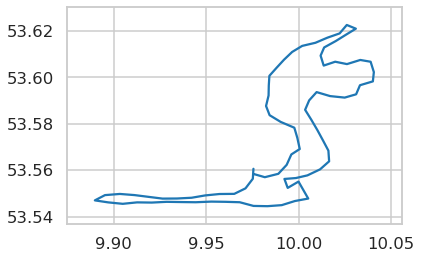

In [9]:
import gpxpy
import mplleaflet
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['axes.xmargin'] = 0.1
plt.rcParams['axes.ymargin'] = 0.1
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

with open('data/test_track.gpx') as fh:
    gpx_file = gpxpy.parse(fh)

segment = gpx_file.tracks[0].segments[0]
coords = pd.DataFrame([{'lat': p.latitude, 'lon': p.longitude} for p in segment.points])
plot_coords = coords.iloc[::150]

fig = plt.figure()
plt.plot(plot_coords['lon'].values, plot_coords['lat'].values);
#plt.plot(plot_coords['lon'].values, plot_coords['lat'].values, 'ro');

In [12]:
mplleaflet.display(fig=fig)

---
# Что существует в данной области?

#### [Google maps](https://www.google.com/maps)
- __Представление карт__  
[Известно](https://docs.google.com/presentation/d/1Hl4KapfAENAOf4gv-pSngKwvS_jwNVHRPZTTDzXXn6Q/view#slide=id.i0), что Google использует open-source [S2 library](https://blog.christianperone.com/2015/08/googles-s2-geometry-on-the-sphere-cells-and-hilbert-curve/) для отражения сферы Земли на т.н. клетки пространства размерности 2. Эти клетки различных уровней позволяют approximate как точечные объекты, так и регионы. [Кривая Гильберта](https://ru.wikipedia.org/wiki/%D0%9A%D1%80%D0%B8%D0%B2%D0%B0%D1%8F_%D0%93%D0%B8%D0%BB%D1%8C%D0%B1%D0%B5%D1%80%D1%82%D0%B0) возволяет уменьшить размерность пространства до 1 (прямая) и тем самым использовать представление клеток в формате int64.
- __Алгоритм__  
В открытом доступе нет информации об алгоритме, используемом Google для поиска маршрута, однако есть информация об использовании алгоритма [contraction hierarchies](https://en.wikipedia.org/wiki/Contraction_hierarchies) для поиска маршрута на графе. Более того, на одном из форумов удалось найти информацию о дискретизации мира, косвенно подтвержденную работниками Google Plyush Khemka и Souvik Kumar Mitra. Согласно ей, мир представим в виде графа, где в качестве вершин выступают "локации", а в качестве ребер - дороги. Это же подтверждают и реальные наблюдения работы алгоритма. Стоит отметить, что впоследствии данная информация была удалена, сохранился [скриншот](https://drive.google.com/file/d/1Eu19cR91D_LVA_HM26xb4918bIxX8c1o/view?usp=sharing).

---
#### [GraphHopper](https://www.graphhopper.com/)
Этот [open-source](https://github.com/graphhopper/graphhopper) routing engine используется как один из двух вариантов при построении маршрута в OpenStreetMap. Информация об алгоритмах доступна: GraphHopper использует алгоритм Дейкстры, А* и contraction hierarchies. Информацию о графе можно найти в исходном коде. В директории /core/files находятся сжатые карты OSM некоторых городов или регионов. [Парсеры](https://github.com/graphhopper/graphhopper/tree/master/core/src/main/java/com/graphhopper/routing/util/parsers) и всевозможные значения данных из карт из папки [ev](https://github.com/graphhopper/graphhopper/tree/master/core/src/main/java/com/graphhopper/routing/ev) используются при [чтении](https://github.com/graphhopper/graphhopper/blob/5c7d08d9df167714a3d9f883339ea6f39f932d99/reader-osm/src/main/java/com/graphhopper/reader/osm/OSMReader.java) данных из OSM файла и последующей инициализации графа. "Preprocessing of OSM file to select nodes which are used for highways. This allows a more compact graph data structure." То есть вершинами [графа](https://github.com/graphhopper/graphhopper/blob/5c7d08d9df167714a3d9f883339ea6f39f932d99/core/src/main/java/com/graphhopper/storage/GraphHopperStorage.java) являются не все точки файла OSM (</ node>), а лишь те, которые задают дороги, а сами дороги являются рбрами. [Веса](https://github.com/graphhopper/graphhopper/tree/5c7d08d9df167714a3d9f883339ea6f39f932d99/core/src/main/java/com/graphhopper/routing/weighting) для алгоритма А* задаются в зависимости от различных параметров: запутанность маршрута, веса на поворотах, расстояние по прямой до итоговой точки и т.д.

---
#### Игры
Полной неожиданностью для меня стало то, что на сегодняшний единственной сферой, где веса для А* задаются в зависимости от рельефа и ландшафта является разработка игр. В основном это игры [point-and-click](https://ru.wikipedia.org/wiki/Point-and-click), в которых перемещение персонажа либо занимает время, либо на это требуются силы, деньги и т.д. Примером является серия игр Sid Meier's Civilization, где тип ландшафта [влияет](http://interesnoeinfo.ru/sid-meiers-civilization-6-landshaft/) на затрачиваемое количество очков передвижения. В играх алгоритмы поиска кратчайшего пути используются для ботов, которым, например, нужно постоянно находить кратчайший путь к игроку [(игры tower defense)](https://www.redblobgames.com/pathfinding/tower-defense/). Имеются [реализации](http://theory.stanford.edu/~amitp/GameProgramming/MovementCosts.html), учитывающие движение по склону, торговые точки и даже расход топлива. Это дает некоторые идеи относительно будущего алгоритма. Помимо прочего, область разработки игр наталкивает и на мысли по поводу представления карт. Там часто используются [графы-сетки](https://www.redblobgames.com/pathfinding/grids/graphs.html), обсуждаются вопросы их достоинств и [оптимизации](https://www.redblobgames.com/pathfinding/grids/algorithms.html). Это важный вопрос дискретизации пространства.

---
# Дальнейшие вопросы
1) выбор алгоритма  
2) дискретизация карты, построение графа